# Crystal Melting Rates

In [80]:
from ipywidgets import interact, ToggleButtons, fixed
import numpy as np
import pandas
import altair as alt
from altair import Chart, X, Y, Color, Scale, Axis, Column, Row, Legend, Header
import scipy.stats
from altair import pipe, limit_rows, to_values
t = lambda data: pipe(data, limit_rows(max_rows=20000), to_values)
alt.data_transformers.register('custom', t)
alt.data_transformers.enable('custom')
alt.renderers.enable('svg')

In [81]:
# Read file with melting data
norm_df = pandas.read_hdf('../data/analysis/melting.h5', 'fractions', mode='r')
norm_df['normed'] = norm_df.volume / norm_df['surface-area']
norm_df.normed.fillna(value=0, inplace=True)

group_bys = ['crystal', 'temperature', 'state', 'pressure']
time_df = norm_df.copy()
time_df.index = pandas.TimedeltaIndex(norm_df.time)
time_df = time_df.groupby(group_bys).resample('1ms').mean().reset_index(group_bys)

df_high = time_df.query('pressure == "13.50"')
df_high = df_high.groupby(group_bys).resample('5ms').mean().reset_index(group_bys)

df_low = norm_df.query('pressure == "1.00"')

In [82]:
def create_figure(temp, dataset):
    c = Chart(dataset.query("temperature == @temp")).mark_line().encode(
        x=X('time', 
            axis=Axis(format='e', title='Timesteps (t)')),
        y=Y('percentage:Q', 
            axis=Axis(title='Percentage of Sites (%)'), 
            scale=Scale(domain=[0, 100])),
        color=Color('state', legend=Legend(title='Classification')),
        column=Column('crystal', header=Header(title='Initial Crystal')),
        row=Row('pressure', header=Header(title='Pressure')),
    ).transform_calculate(
        'percentage', 'datum.fraction * 100'
    )
    return c

def compute_melting_rates(df):
    slopes = []
    for index, group in df.groupby(['temperature', 'pressure', 'crystal']):
        # find fraction melted
        subgroup =  group.query('state == "liq" and fraction < 0.95')
        if len(subgroup) < 5:
            break
        slope, *_ = scipy.stats.linregress(subgroup.time, subgroup.normed)
        slopes.append((*index, slope))

    melt = pandas.DataFrame(slopes)
    melt.columns = ['temperature', 'pressure', 'crys', 'melting_rate']
    melt.temperature = melt.temperature.astype(float)
    melt.melting_rate = melt.melting_rate
    return melt

## Low Pressure

In [83]:
temp_select = ToggleButtons(
    options=sorted(df_low.temperature.unique()),
    description='Temperature:',
)

interact(create_figure, temp=temp_select, dataset=fixed(df_low))

interactive(children=(ToggleButtons(description='Temperature:', options=('0.30', '0.35', '0.40', '0.45', '0.50', '0.60', '0.80', '1.00', '1.20', '1.30'), value='0.30'), Output()), _dom_classes=('widget-interact',))

<function __main__.create_figure>

In [94]:
melt_low = compute_melting_rates(df_low)

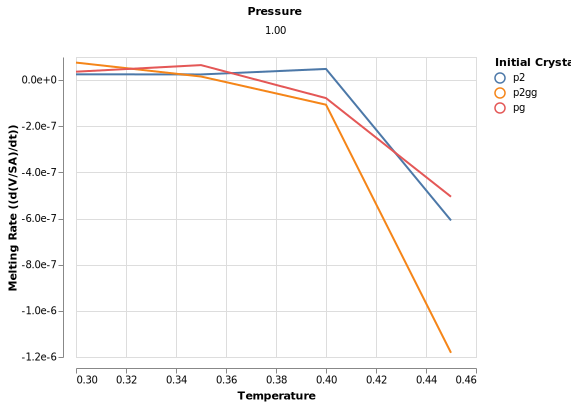

In [95]:
Chart(melt_low).mark_line().encode(
    x=X('temperature', axis=Axis(title='Temperature'), scale=Scale(zero=False)),
    y=Y('melting_rate', axis=Axis(format='e', title='Melting Rate ((d(V/SA)/dt))')),
    color=Color('crys', legend=alt.Legend(title='Initial Crystal')),
    column=Column('pressure', header=alt.Header(title='Pressure')), 
)

## High Pressure

In [96]:
temp_select = ToggleButtons(
    options=sorted(df_high.temperature.unique()),
    description='Temperature:',
)

interact(create_figure, temp=temp_select, dataset=fixed(df_high))

interactive(children=(ToggleButtons(description='Temperature:', options=('1.30', '1.35', '1.40', '1.45', '1.50'), value='1.30'), Output()), _dom_classes=('widget-interact',))

<function __main__.create_figure>

In [97]:
melt_high = compute_melting_rates(df_high)

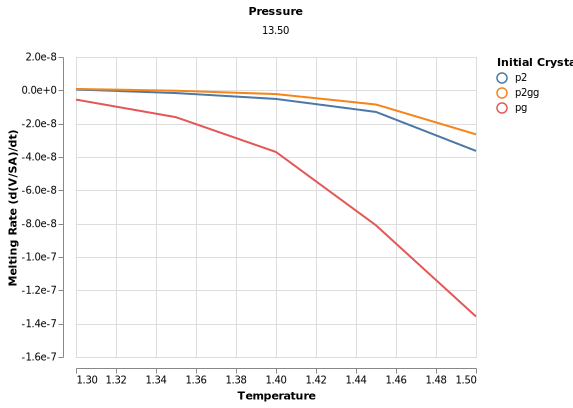

In [98]:
Chart(melt_high).mark_line().encode(
    x=X('temperature', axis=Axis(title='Temperature'), scale=Scale(zero=False)),
    y=Y('melting_rate', axis=Axis(format='e', title='Melting Rate (d(V/SA)/dt)')),
    color=Color('crys', legend=alt.Legend(title='Initial Crystal')),
    column=Column('pressure', header=alt.Header(title='Pressure')), 
)